# Inspection Notebook

In [41]:
from pynwb import NWBHDF5IO
import numpy as np
import matplotlib.pyplot as plt
import datajoint as dj
from pathlib import Path
import sys
import networkx as nx
import pandas as pd

dj_local_conf_path = "/Users/pauladkisson/Documents/CatalystNeuro/JadhavConv/jadhav-lab-to-nwb/src/jadhav_lab_to_nwb/spyglass_mock/dj_local_conf.json"
dj.config.load(dj_local_conf_path)  # load config for database connection info

# General Spyglass Imports
import spyglass.common as sgc  # this import connects to the database
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename

# DLC Imports
from spyglass.position.v1.imported_pose import ImportedPose

# Custom Table Imports
sys.path.append(
    "/Users/pauladkisson/Documents/CatalystNeuro/JadhavConv/jadhav-lab-to-nwb/src/jadhav_lab_to_nwb/spyglass_extensions"
)
from task_leds import TaskLEDs

[2025-06-26 09:44:40,074][INFO]: DataJoint is configured from /Users/pauladkisson/Documents/CatalystNeuro/JadhavConv/jadhav-lab-to-nwb/src/jadhav_lab_to_nwb/spyglass_mock/dj_local_conf.json


This notebook inspects each of the 24 example sessions (12 pairs) for rivera_and_shukla_2025 conversion to ensure their quality.

In [42]:
sgc.Session()

[2025-06-26 09:44:43,789][WARNING]: Reconnecting to MySQL server.


nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
sub-XFN1_ses-07-15-2023-100_.nwb,XFN1,Brandeis University,Jadhav,07-15-2023-100,Rats performed a cooperative maze task in which a pair of rats must cooperate by picking the same well in order to get a joint reward. Rewards were delivered 100% of the time when both rats poked the same well.,2023-07-15 00:00:00,2023-07-15 00:00:00,"Pro-social behaviors involve affiliative social interactions between individuals aimed at either mutual benefits for individuals involved or benefiting others. These behaviors are essential for social cohesiveness and well-being of social species. Individuals with autism spectrum disorders have severe cognitive and social deficits. However, little is known about the underlying causes and neural mechanisms associated with these deficits. Our study involves looking into the behavior of wild-type and Fmr1-/y rat pairs on W mazes where they are required to cooperate in order to get a joint reward."
sub-XFN1_ses-07-20-2023-100_.nwb,XFN1,Brandeis University,Jadhav,07-20-2023-100,Rats performed a cooperative maze task in which a pair of rats must cooperate by picking the same well in order to get a joint reward. Rewards were delivered 100% of the time when both rats poked the same well.,2023-07-20 00:00:00,2023-07-20 00:00:00,"Pro-social behaviors involve affiliative social interactions between individuals aimed at either mutual benefits for individuals involved or benefiting others. These behaviors are essential for social cohesiveness and well-being of social species. Individuals with autism spectrum disorders have severe cognitive and social deficits. However, little is known about the underlying causes and neural mechanisms associated with these deficits. Our study involves looking into the behavior of wild-type and Fmr1-/y rat pairs on W mazes where they are required to cooperate in order to get a joint reward."
sub-XFN1_ses-07-27-2023-100_.nwb,XFN1,Brandeis University,Jadhav,07-27-2023-100,Rats performed a cooperative maze task in which a pair of rats must cooperate by picking the same well in order to get a joint reward. Rewards were delivered 100% of the time when both rats poked the same well.,2023-07-27 00:00:00,2023-07-27 00:00:00,"Pro-social behaviors involve affiliative social interactions between individuals aimed at either mutual benefits for individuals involved or benefiting others. These behaviors are essential for social cohesiveness and well-being of social species. Individuals with autism spectrum disorders have severe cognitive and social deficits. However, little is known about the underlying causes and neural mechanisms associated with these deficits. Our study involves looking into the behavior of wild-type and Fmr1-/y rat pairs on W mazes where they are required to cooperate in order to get a joint reward."
sub-XFN1_ses-08-03-2023-50_.nwb,XFN1,Brandeis University,Jadhav,08-03-2023-50,Rats performed a cooperative maze task in which a pair of rats must cooperate by picking the same well in order to get a joint reward. Rewards were delivered 50% of the time when both rats poked the same well.,2023-08-03 00:00:00,2023-08-03 00:00:00,"Pro-social behaviors involve affiliative social interactions between individuals aimed at either mutual benefits for individuals involved or benefiting others. These behaviors are essential for social cohesiveness and well-being of social species. Individuals with autism spectrum disorders have severe cognitive and social deficits. However, little is known about the underlying causes and neural mechanisms associated with these deficits. Our study involves looking into the behavior of wild-type and Fmr1-/y rat pairs on W mazes where they are required to cooperate in order to get a joint reward."
sub-XFN1_ses-08-07-2023-50_.nwb,XFN1,Brandeis University,Jadhav,08-07-2023-50,Rats performed a c

## Checking Functions

In [140]:
def validate_nwb_session_pair(nwb_file_path_1, nwb_file_path_2, subject_1="XFN1", subject_2="XFN3"):
    """
    Validate consistency between two NWB files and their corresponding Spyglass database entries.
    
    Parameters:
    -----------
    nwb_file_path_1 : str or Path
        Path to the first NWB file
    nwb_file_path_2 : str or Path  
        Path to the second NWB file
    subject_1 : str, default "XFN1"
        Subject identifier for first file
    subject_2 : str, default "XFN3"
        Subject identifier for second file
        
    Raises:
    -------
    AssertionError
        If any validation check fails
    """
    # Convert to Path objects
    nwb_file_path_1 = Path(nwb_file_path_1)
    nwb_file_path_2 = Path(nwb_file_path_2)
    
    # Extract data from first NWB file
    with NWBHDF5IO(nwb_file_path_1, "r") as io:
        nwbfile = io.read()

        # Get Behavior data
        behavioral_events = nwbfile.processing["behavior"].data_interfaces["behavioral_events"].time_series
        
        matched_poke_A1_1 = behavioral_events["matched_poke_A1"].timestamps[:]
        matched_poke_B2_1 = behavioral_events["matched_poke_B2"].timestamps[:]
        matched_poke_C3_1 = behavioral_events["matched_poke_C3"].timestamps[:]
        reward_well_1_1 = behavioral_events["reward_well_1"].timestamps[:]
        reward_well_2_1 = behavioral_events["reward_well_2"].timestamps[:]
        reward_well_3_1 = behavioral_events["reward_well_3"].timestamps[:]
        reward_well_A_1 = behavioral_events["reward_well_A"].timestamps[:]
        reward_well_B_1 = behavioral_events["reward_well_B"].timestamps[:]
        reward_well_C_1 = behavioral_events["reward_well_C"].timestamps[:]
        rewarded_poke_1 = behavioral_events["rewarded_poke"].timestamps[:]

        # Get DLC data for both subjects
        pose_interfaces = nwbfile.processing["behavior"].data_interfaces
        
        # Subject 1 pose estimation
        pe_key_1_1 = f"PoseEstimation_1-{subject_1}-1"
        nodes_1_1 = pose_interfaces[pe_key_1_1].nodes[:]
        edges_1_1 = pose_interfaces[pe_key_1_1].edges[:]
        pes_1_1 = pose_interfaces[pe_key_1_1].pose_estimation_series
        name_to_data_1_1 = {name: series.data[:] for name, series in pes_1_1.items()}
        pes_timestamps_1_1 = pes_1_1["PoseEstimationSeriesBody center"].timestamps[:]
        
        # Subject 2 pose estimation  
        pe_key_1_2 = f"PoseEstimation_1-{subject_2}-1"
        nodes_1_2 = pose_interfaces[pe_key_1_2].nodes[:]
        edges_1_2 = pose_interfaces[pe_key_1_2].edges[:]
        pes_1_2 = pose_interfaces[pe_key_1_2].pose_estimation_series
        name_to_data_1_2 = {name: series.data[:] for name, series in pes_1_2.items()}
        pes_timestamps_1_2 = pes_1_2["PoseEstimationSeriesBody center"].timestamps[:]

        # Get Video data
        video_key = f"Video_1-{subject_1}-{subject_2}"
        video_external_file_1 = nwbfile.acquisition[video_key].external_file[:]
        video_timestamps_1 = nwbfile.acquisition[video_key].timestamps[:]

        # Get Tables
        epochs_1 = nwbfile.epochs.to_dataframe()
        task_key_1 = f"SocialW_Left" if subject_1 == "XFN1" else "SocialW_Right"
        tasks_1 = nwbfile.processing["tasks"].data_interfaces[task_key_1].to_dataframe()
        invalid_times_1 = nwbfile.invalid_times.to_dataframe()

    # Extract data from Spyglass for first file
    nwb_copy_file_name_1 = get_nwb_copy_filename(nwb_file_path_1.name)
    
    # Get Behavior from Spyglass
    matched_poke_A1_1_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name_1, "dio_event_name": "matched_poke_A1"}).fetch_nwb()[0]["dio"].timestamps[:]
    matched_poke_B2_1_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name_1, "dio_event_name": "matched_poke_B2"}).fetch_nwb()[0]["dio"].timestamps[:]
    matched_poke_C3_1_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name_1, "dio_event_name": "matched_poke_C3"}).fetch_nwb()[0]["dio"].timestamps[:]
    reward_well_1_1_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name_1, "dio_event_name": "reward_well_1"}).fetch_nwb()[0]["dio"].timestamps[:]
    reward_well_2_1_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name_1, "dio_event_name": "reward_well_2"}).fetch_nwb()[0]["dio"].timestamps[:]
    reward_well_3_1_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name_1, "dio_event_name": "reward_well_3"}).fetch_nwb()[0]["dio"].timestamps[:]
    reward_well_A_1_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name_1, "dio_event_name": "reward_well_A"}).fetch_nwb()[0]["dio"].timestamps[:]
    reward_well_B_1_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name_1, "dio_event_name": "reward_well_B"}).fetch_nwb()[0]["dio"].timestamps[:]
    reward_well_C_1_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name_1, "dio_event_name": "reward_well_C"}).fetch_nwb()[0]["dio"].timestamps[:]
    rewarded_poke_1_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name_1, "dio_event_name": "rewarded_poke"}).fetch_nwb()[0]["dio"].timestamps[:]

    # Get DLC from Spyglass
    interval_name_1_1 = f"pose_PoseEstimation_1-{subject_1}-1_valid_intervals"
    pose_data_1_1_spyglass = (ImportedPose & {
        "nwb_file_name": nwb_copy_file_name_1, 
        "interval_list_name": interval_name_1_1
    }).fetch_nwb()[0]["pose"]
    
    nodes_1_1_spyglass = pose_data_1_1_spyglass.nodes[:]
    edges_1_1_spyglass = pose_data_1_1_spyglass.edges[:]
    pes_1_1_spyglass = pose_data_1_1_spyglass.pose_estimation_series
    name_to_data_1_1_spyglass = {name: series.data[:] for name, series in pes_1_1_spyglass.items()}
    pes_timestamps_1_1_spyglass = pes_1_1_spyglass["PoseEstimationSeriesBody center"].timestamps[:]

    interval_name_1_2 = f"pose_PoseEstimation_1-{subject_2}-1_valid_intervals"
    pose_data_1_2_spyglass = (ImportedPose & {
        "nwb_file_name": nwb_copy_file_name_1, 
        "interval_list_name": interval_name_1_2
    }).fetch_nwb()[0]["pose"]
    
    nodes_1_2_spyglass = pose_data_1_2_spyglass.nodes[:]
    edges_1_2_spyglass = pose_data_1_2_spyglass.edges[:]
    pes_1_2_spyglass = pose_data_1_2_spyglass.pose_estimation_series
    name_to_data_1_2_spyglass = {name: series.data[:] for name, series in pes_1_2_spyglass.items()}
    pes_timestamps_1_2_spyglass = pes_1_2_spyglass["PoseEstimationSeriesBody center"].timestamps[:]

    # Get Video from Spyglass
    image_series_1 = (sgc.VideoFile & {
        "nwb_file_name": nwb_copy_file_name_1, 
        "epoch": 1
    }).fetch_nwb()[0]["video_file"]
    video_external_file_1_spyglass = image_series_1.external_file[:]
    video_timestamps_1_spyglass = image_series_1.timestamps[:]

    # Get Tables from Spyglass
    epochs_1_spyglass = []
    for i, row in epochs_1.iterrows():
        interval_list_name = row["tags"][0]
        df = pd.DataFrame((sgc.IntervalList & {
            "nwb_file_name": nwb_copy_file_name_1, 
            "interval_list_name": interval_list_name
        }).fetch())
        epochs_1_spyglass.append(df)
    epochs_1_spyglass = pd.concat(epochs_1_spyglass, ignore_index=True)

    task_epochs_1_spyglass = []
    for epoch in tasks_1.task_epochs[0]:
        df = pd.DataFrame((sgc.TaskEpoch & {
            "nwb_file_name": nwb_copy_file_name_1, 
            "epoch": epoch
        }).fetch())
        task_epochs_1_spyglass.append(df)
    task_epochs_1_spyglass = pd.concat(task_epochs_1_spyglass, ignore_index=True)

    invalid_times_1_spyglass = []
    for i, row in invalid_times_1.iterrows():
        interval_list_name = f"{row['tag']}_invalid_intervals"
        df = pd.DataFrame((sgc.IntervalList & {
            "nwb_file_name": nwb_copy_file_name_1, 
            "interval_list_name": interval_list_name
        }).fetch())
        invalid_times_1_spyglass.append(df)
    invalid_times_1_spyglass = pd.concat(invalid_times_1_spyglass, ignore_index=True)

    # Extract data from second NWB file
    with NWBHDF5IO(nwb_file_path_2, "r") as io:
        nwbfile = io.read()

        # Get Behavior data
        behavioral_events = nwbfile.processing["behavior"].data_interfaces["behavioral_events"].time_series
        
        matched_poke_A1_2 = behavioral_events["matched_poke_A1"].timestamps[:]
        matched_poke_B2_2 = behavioral_events["matched_poke_B2"].timestamps[:]
        matched_poke_C3_2 = behavioral_events["matched_poke_C3"].timestamps[:]
        reward_well_1_2 = behavioral_events["reward_well_1"].timestamps[:]
        reward_well_2_2 = behavioral_events["reward_well_2"].timestamps[:]
        reward_well_3_2 = behavioral_events["reward_well_3"].timestamps[:]
        reward_well_A_2 = behavioral_events["reward_well_A"].timestamps[:]
        reward_well_B_2 = behavioral_events["reward_well_B"].timestamps[:]
        reward_well_C_2 = behavioral_events["reward_well_C"].timestamps[:]
        rewarded_poke_2 = behavioral_events["rewarded_poke"].timestamps[:]

        # Get DLC data
        pose_interfaces = nwbfile.processing["behavior"].data_interfaces
        
        # Subject 1 pose estimation
        pe_key_2_1 = f"PoseEstimation_1-{subject_1}-1"
        nodes_2_1 = pose_interfaces[pe_key_2_1].nodes[:]
        edges_2_1 = pose_interfaces[pe_key_2_1].edges[:]
        pes_2_1 = pose_interfaces[pe_key_2_1].pose_estimation_series
        name_to_data_2_1 = {name: series.data[:] for name, series in pes_2_1.items()}
        pes_timestamps_2_1 = pes_2_1["PoseEstimationSeriesBody center"].timestamps[:]
        
        # Subject 2 pose estimation
        pe_key_2_2 = f"PoseEstimation_1-{subject_2}-1"
        nodes_2_2 = pose_interfaces[pe_key_2_2].nodes[:]
        edges_2_2 = pose_interfaces[pe_key_2_2].edges[:]
        pes_2_2 = pose_interfaces[pe_key_2_2].pose_estimation_series
        name_to_data_2_2 = {name: series.data[:] for name, series in pes_2_2.items()}
        pes_timestamps_2_2 = pes_2_2["PoseEstimationSeriesBody center"].timestamps[:]

        # Get Video data
        video_external_file_2 = nwbfile.acquisition[video_key].external_file[:]
        video_timestamps_2 = nwbfile.acquisition[video_key].timestamps[:]

        # Get Tables
        epochs_2 = nwbfile.epochs.to_dataframe()
        task_key_2 = f"SocialW_Right" if subject_2 == "XFN3" else "SocialW_Left"
        tasks_2 = nwbfile.processing["tasks"].data_interfaces[task_key_2].to_dataframe()
        invalid_times_2 = nwbfile.invalid_times.to_dataframe()

    # Extract data from Spyglass for second file
    nwb_copy_file_name_2 = get_nwb_copy_filename(nwb_file_path_2.name)
    
    # Get Behavior from Spyglass
    matched_poke_A1_2_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name_2, "dio_event_name": "matched_poke_A1"}).fetch_nwb()[0]["dio"].timestamps[:]
    matched_poke_B2_2_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name_2, "dio_event_name": "matched_poke_B2"}).fetch_nwb()[0]["dio"].timestamps[:]
    matched_poke_C3_2_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name_2, "dio_event_name": "matched_poke_C3"}).fetch_nwb()[0]["dio"].timestamps[:]
    reward_well_1_2_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name_2, "dio_event_name": "reward_well_1"}).fetch_nwb()[0]["dio"].timestamps[:]
    reward_well_2_2_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name_2, "dio_event_name": "reward_well_2"}).fetch_nwb()[0]["dio"].timestamps[:]
    reward_well_3_2_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name_2, "dio_event_name": "reward_well_3"}).fetch_nwb()[0]["dio"].timestamps[:]
    reward_well_A_2_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name_2, "dio_event_name": "reward_well_A"}).fetch_nwb()[0]["dio"].timestamps[:]
    reward_well_B_2_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name_2, "dio_event_name": "reward_well_B"}).fetch_nwb()[0]["dio"].timestamps[:]
    reward_well_C_2_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name_2, "dio_event_name": "reward_well_C"}).fetch_nwb()[0]["dio"].timestamps[:]
    rewarded_poke_2_spyglass = (sgc.DIOEvents & {"nwb_file_name": nwb_copy_file_name_2, "dio_event_name": "rewarded_poke"}).fetch_nwb()[0]["dio"].timestamps[:]

    # Get DLC from Spyglass
    interval_name_2_1 = f"pose_PoseEstimation_1-{subject_1}-1_valid_intervals"
    pose_data_2_1_spyglass = (ImportedPose & {
        "nwb_file_name": nwb_copy_file_name_2, 
        "interval_list_name": interval_name_2_1
    }).fetch_nwb()[0]["pose"]
    
    nodes_2_1_spyglass = pose_data_2_1_spyglass.nodes[:]
    edges_2_1_spyglass = pose_data_2_1_spyglass.edges[:]
    pes_2_1_spyglass = pose_data_2_1_spyglass.pose_estimation_series
    name_to_data_2_1_spyglass = {name: series.data[:] for name, series in pes_2_1_spyglass.items()}
    pes_timestamps_2_1_spyglass = pes_2_1_spyglass["PoseEstimationSeriesBody center"].timestamps[:]

    interval_name_2_2 = f"pose_PoseEstimation_1-{subject_2}-1_valid_intervals"
    pose_data_2_2_spyglass = (ImportedPose & {
        "nwb_file_name": nwb_copy_file_name_2, 
        "interval_list_name": interval_name_2_2
    }).fetch_nwb()[0]["pose"]
    
    nodes_2_2_spyglass = pose_data_2_2_spyglass.nodes[:]
    edges_2_2_spyglass = pose_data_2_2_spyglass.edges[:]
    pes_2_2_spyglass = pose_data_2_2_spyglass.pose_estimation_series
    name_to_data_2_2_spyglass = {name: series.data[:] for name, series in pes_2_2_spyglass.items()}
    pes_timestamps_2_2_spyglass = pes_2_2_spyglass["PoseEstimationSeriesBody center"].timestamps[:]

    # Get Video from Spyglass
    image_series_2 = (sgc.VideoFile & {
        "nwb_file_name": nwb_copy_file_name_2, 
        "epoch": 1
    }).fetch_nwb()[0]["video_file"]
    video_external_file_2_spyglass = image_series_2.external_file[:]
    video_timestamps_2_spyglass = image_series_2.timestamps[:]

    # Get Tables from Spyglass
    epochs_2_spyglass = []
    for i, row in epochs_2.iterrows():
        interval_list_name = row["tags"][0]
        df = pd.DataFrame((sgc.IntervalList & {
            "nwb_file_name": nwb_copy_file_name_2, 
            "interval_list_name": interval_list_name
        }).fetch())
        epochs_2_spyglass.append(df)
    epochs_2_spyglass = pd.concat(epochs_2_spyglass, ignore_index=True)

    task_epochs_2_spyglass = []
    for epoch in tasks_2.task_epochs[0]:
        df = pd.DataFrame((sgc.TaskEpoch & {
            "nwb_file_name": nwb_copy_file_name_2, 
            "epoch": epoch
        }).fetch())
        task_epochs_2_spyglass.append(df)
    task_epochs_2_spyglass = pd.concat(task_epochs_2_spyglass, ignore_index=True)

    invalid_times_2_spyglass = []
    for i, row in invalid_times_2.iterrows():
        interval_list_name = f"{row['tag']}_invalid_intervals"
        df = pd.DataFrame((sgc.IntervalList & {
            "nwb_file_name": nwb_copy_file_name_2, 
            "interval_list_name": interval_list_name
        }).fetch())
        invalid_times_2_spyglass.append(df)
    invalid_times_2_spyglass = pd.concat(invalid_times_2_spyglass, ignore_index=True)

    # VALIDATION ASSERTIONS
    
    # Check consistency within first file data
    tolerance = 5.0  # seconds
    for timestamp in matched_poke_A1_1:
        assert np.any(np.abs(reward_well_1_1 - timestamp) <= tolerance), f"Matched poke A1 timestamp {timestamp} not found within {tolerance}s in reward well 1"
        assert np.any(np.abs(reward_well_A_1 - timestamp) <= tolerance), f"Matched poke A1 timestamp {timestamp} not found within {tolerance}s in reward well A"
    
    for timestamp in matched_poke_B2_1:
        assert np.any(np.abs(reward_well_2_1 - timestamp) <= tolerance), f"Matched poke B2 timestamp {timestamp} not found within {tolerance}s in reward well 2"
        assert np.any(np.abs(reward_well_B_1 - timestamp) <= tolerance), f"Matched poke B2 timestamp {timestamp} not found within {tolerance}s in reward well B"
        
    for timestamp in matched_poke_C3_1:
        assert np.any(np.abs(reward_well_3_1 - timestamp) <= tolerance), f"Matched poke C3 timestamp {timestamp} not found within {tolerance}s in reward well 3"
        assert np.any(np.abs(reward_well_C_1 - timestamp) <= tolerance), f"Matched poke C3 timestamp {timestamp} not found within {tolerance}s in reward well C"
        
    all_matched_pokes_1 = np.sort(np.concatenate((matched_poke_A1_1, matched_poke_B2_1, matched_poke_C3_1)))
    np.testing.assert_array_equal(rewarded_poke_1, all_matched_pokes_1, "Rewarded poke timestamps do not match all matched pokes in first file")
    np.testing.assert_array_equal(video_timestamps_1[:len(pes_timestamps_1_1)], pes_timestamps_1_1, f"Video timestamps do not match DLC timestamps for {subject_1} in first file")

    # Check consistency within second file data
    for timestamp in matched_poke_A1_2:
        assert np.any(np.abs(reward_well_1_2 - timestamp) <= tolerance), f"Matched poke A1 timestamp {timestamp} not found within {tolerance}s in reward well 1 for second file"
        assert np.any(np.abs(reward_well_A_2 - timestamp) <= tolerance), f"Matched poke A1 timestamp {timestamp} not found within {tolerance}s in reward well A for second file"
    
    for timestamp in matched_poke_B2_2:
        assert np.any(np.abs(reward_well_2_2 - timestamp) <= tolerance), f"Matched poke B2 timestamp {timestamp} not found within {tolerance}s in reward well 2 for second file"
        assert np.any(np.abs(reward_well_B_2 - timestamp) <= tolerance), f"Matched poke B2 timestamp {timestamp} not found within {tolerance}s in reward well B for second file"
        
    for timestamp in matched_poke_C3_2:
        assert np.any(np.abs(reward_well_3_2 - timestamp) <= tolerance), f"Matched poke C3 timestamp {timestamp} not found within {tolerance}s in reward well 3 for second file"
        assert np.any(np.abs(reward_well_C_2 - timestamp) <= tolerance), f"Matched poke C3 timestamp {timestamp} not found within {tolerance}s in reward well C for second file"
        
    all_matched_pokes_2 = np.sort(np.concatenate((matched_poke_A1_2, matched_poke_B2_2, matched_poke_C3_2)))
    np.testing.assert_array_equal(rewarded_poke_2, all_matched_pokes_2, "Rewarded poke timestamps do not match all matched pokes in second file")
    np.testing.assert_array_equal(video_timestamps_2[:len(pes_timestamps_2_2)], pes_timestamps_2_2, f"Video timestamps do not match DLC timestamps for {subject_2} in second file")

    # Check consistency between files
    # Behavior
    np.testing.assert_array_equal(matched_poke_A1_1, matched_poke_A1_2, f"Matched poke A1 timestamps differ between {subject_1} and {subject_2}")
    np.testing.assert_array_equal(matched_poke_B2_1, matched_poke_B2_2, f"Matched poke B2 timestamps differ between {subject_1} and {subject_2}")
    np.testing.assert_array_equal(matched_poke_C3_1, matched_poke_C3_2, f"Matched poke C3 timestamps differ between {subject_1} and {subject_2}")
    np.testing.assert_array_equal(reward_well_1_1, reward_well_1_2, f"Reward well 1 timestamps differ between {subject_1} and {subject_2}")
    np.testing.assert_array_equal(reward_well_2_1, reward_well_2_2, f"Reward well 2 timestamps differ between {subject_1} and {subject_2}")
    np.testing.assert_array_equal(reward_well_3_1, reward_well_3_2, f"Reward well 3 timestamps differ between {subject_1} and {subject_2}")
    np.testing.assert_array_equal(reward_well_A_1, reward_well_A_2, f"Reward well A timestamps differ between {subject_1} and {subject_2}")
    np.testing.assert_array_equal(reward_well_B_1, reward_well_B_2, f"Reward well B timestamps differ between {subject_1} and {subject_2}")
    np.testing.assert_array_equal(reward_well_C_1, reward_well_C_2, f"Reward well C timestamps differ between {subject_1} and {subject_2}")
    np.testing.assert_array_equal(rewarded_poke_1, rewarded_poke_2, f"Rewarded poke timestamps differ between {subject_1} and {subject_2}")
    
    # DLC
    np.testing.assert_array_equal(nodes_1_1, nodes_2_1, f"DLC nodes differ between {subject_1} and {subject_2} for {subject_1} data")
    np.testing.assert_array_equal(edges_1_1, edges_2_1, f"DLC edges differ between {subject_1} and {subject_2} for {subject_1} data")
    for name, data in name_to_data_1_1.items():
        np.testing.assert_array_equal(data, name_to_data_2_1[name], f"DLC data for {name} differs between {subject_1} and {subject_2} for {subject_1} data")
    np.testing.assert_array_equal(pes_timestamps_1_1, pes_timestamps_2_1, f"DLC timestamps differ between {subject_1} and {subject_2} for {subject_1} data")
    
    np.testing.assert_array_equal(nodes_1_2, nodes_2_2, f"DLC nodes differ between {subject_1} and {subject_2} for {subject_2} data")
    np.testing.assert_array_equal(edges_1_2, edges_2_2, f"DLC edges differ between {subject_1} and {subject_2} for {subject_2} data")
    for name, data in name_to_data_1_2.items():
        np.testing.assert_array_equal(data, name_to_data_2_2[name], f"DLC data for {name} differs between {subject_1} and {subject_2} for {subject_2} data")
    np.testing.assert_array_equal(pes_timestamps_1_2, pes_timestamps_2_2, f"DLC timestamps differ between {subject_1} and {subject_2} for {subject_2} data")
    
    # Video
    np.testing.assert_array_equal(video_external_file_1, video_external_file_2, f"Video external files differ between {subject_1} and {subject_2}")
    np.testing.assert_array_equal(video_timestamps_1, video_timestamps_2, f"Video timestamps differ between {subject_1} and {subject_2}")

    # Check consistency between original NWB and Spyglass data for first file
    # Behavior
    np.testing.assert_array_equal(matched_poke_A1_1, matched_poke_A1_1_spyglass, f"Matched poke A1 timestamps differ between original NWB and Spyglass for {subject_1}")
    np.testing.assert_array_equal(matched_poke_B2_1, matched_poke_B2_1_spyglass, f"Matched poke B2 timestamps differ between original NWB and Spyglass for {subject_1}")
    np.testing.assert_array_equal(matched_poke_C3_1, matched_poke_C3_1_spyglass, f"Matched poke C3 timestamps differ between original NWB and Spyglass for {subject_1}")
    np.testing.assert_array_equal(reward_well_1_1, reward_well_1_1_spyglass, f"Reward well 1 timestamps differ between original NWB and Spyglass for {subject_1}")
    np.testing.assert_array_equal(reward_well_2_1, reward_well_2_1_spyglass, f"Reward well 2 timestamps differ between original NWB and Spyglass for {subject_1}")
    np.testing.assert_array_equal(reward_well_3_1, reward_well_3_1_spyglass, f"Reward well 3 timestamps differ between original NWB and Spyglass for {subject_1}")
    np.testing.assert_array_equal(reward_well_A_1, reward_well_A_1_spyglass, f"Reward well A timestamps differ between original NWB and Spyglass for {subject_1}")
    np.testing.assert_array_equal(reward_well_B_1, reward_well_B_1_spyglass, f"Reward well B timestamps differ between original NWB and Spyglass for {subject_1}")
    np.testing.assert_array_equal(reward_well_C_1, reward_well_C_1_spyglass, f"Reward well C timestamps differ between original NWB and Spyglass for {subject_1}")
    np.testing.assert_array_equal(rewarded_poke_1, rewarded_poke_1_spyglass, f"Rewarded poke timestamps differ between original NWB and Spyglass for {subject_1}")
    
    # DLC
    np.testing.assert_array_equal(nodes_1_1, nodes_1_1_spyglass, f"DLC nodes differ between original NWB and Spyglass for {subject_1}")
    np.testing.assert_array_equal(edges_1_1, edges_1_1_spyglass, f"DLC edges differ between original NWB and Spyglass for {subject_1}")
    for name, data in name_to_data_1_1_spyglass.items():
        np.testing.assert_array_equal(data, name_to_data_1_1[name], f"DLC data for {name} differs between original NWB and Spyglass for {subject_1}")
    np.testing.assert_array_equal(pes_timestamps_1_1, pes_timestamps_1_1_spyglass, f"DLC timestamps differ between original NWB and Spyglass for {subject_1}")
    
    np.testing.assert_array_equal(nodes_1_2, nodes_1_2_spyglass, f"DLC nodes differ between original NWB and Spyglass for {subject_2}")
    np.testing.assert_array_equal(edges_1_2, edges_1_2_spyglass, f"DLC edges differ between original NWB and Spyglass for {subject_2}")
    for name, data in name_to_data_1_2_spyglass.items():
        np.testing.assert_array_equal(data, name_to_data_1_2[name], f"DLC data for {name} differs between original NWB and Spyglass for {subject_2}")
    np.testing.assert_array_equal(pes_timestamps_1_2, pes_timestamps_1_2_spyglass, f"DLC timestamps differ between original NWB and Spyglass for {subject_2}")
    
    # Video
    np.testing.assert_array_equal(video_external_file_1, video_external_file_1_spyglass, f"Video external files differ between original NWB and Spyglass for {subject_1}")
    np.testing.assert_array_equal(video_timestamps_1, video_timestamps_1_spyglass, f"Video timestamps differ between original NWB and Spyglass for {subject_1}")
    
    # Tables
    # Epochs
    for i, row in epochs_1.iterrows():
        row_spyglass = epochs_1_spyglass.iloc[i]
        start_time = row["start_time"]
        stop_time = row["stop_time"]
        start_time_spyglass = row_spyglass["valid_times"][0][0]
        stop_time_spyglass = row_spyglass["valid_times"][0][1]
        assert start_time == start_time_spyglass, f"Epoch {i} start time differs between original NWB and Spyglass for {subject_1}"
        assert stop_time == stop_time_spyglass, f"Epoch {i} stop time differs between original NWB and Spyglass for {subject_1}"
    
    # Tasks
    row = tasks_1.iloc[0]
    task_name = row["task_name"]
    task_environment = row["task_environment"]
    for i, row in task_epochs_1_spyglass.iterrows():
        task_name_spyglass = row["task_name"]
        task_environment_spyglass = row["task_environment"]
        assert task_name == task_name_spyglass, f"Task epoch {i} task name differs between original NWB and Spyglass for {subject_1}"
        assert task_environment == task_environment_spyglass, f"Task epoch {i} task environment differs between original NWB and Spyglass for {subject_1}"
    
    # Invalid Times
    for i, row in invalid_times_1.iterrows():
        row_spyglass = invalid_times_1_spyglass.iloc[i]
        start_time = row["start_time"]
        stop_time = row["stop_time"]
        start_time_spyglass = row_spyglass["valid_times"][0][0]
        stop_time_spyglass = row_spyglass["valid_times"][0][1]
        assert start_time == start_time_spyglass, f"Invalid time {i} start time differs between original NWB and Spyglass for {subject_1}"
        assert stop_time == stop_time_spyglass, f"Invalid time {i} stop time differs between original NWB and Spyglass for {subject_1}"

    # Check consistency between original NWB and Spyglass data for second file
    # Behavior
    np.testing.assert_array_equal(matched_poke_A1_2, matched_poke_A1_2_spyglass, f"Matched poke A1 timestamps differ between original NWB and Spyglass for {subject_2}")
    np.testing.assert_array_equal(matched_poke_B2_2, matched_poke_B2_2_spyglass, f"Matched poke B2 timestamps differ between original NWB and Spyglass for {subject_2}")
    np.testing.assert_array_equal(matched_poke_C3_2, matched_poke_C3_2_spyglass, f"Matched poke C3 timestamps differ between original NWB and Spyglass for {subject_2}")
    np.testing.assert_array_equal(reward_well_1_2, reward_well_1_2_spyglass, f"Reward well 1 timestamps differ between original NWB and Spyglass for {subject_2}")
    np.testing.assert_array_equal(reward_well_2_2, reward_well_2_2_spyglass, f"Reward well 2 timestamps differ between original NWB and Spyglass for {subject_2}")
    np.testing.assert_array_equal(reward_well_3_2, reward_well_3_2_spyglass, f"Reward well 3 timestamps differ between original NWB and Spyglass for {subject_2}")
    np.testing.assert_array_equal(reward_well_A_2, reward_well_A_2_spyglass, f"Reward well A timestamps differ between original NWB and Spyglass for {subject_2}")
    np.testing.assert_array_equal(reward_well_B_2, reward_well_B_2_spyglass, f"Reward well B timestamps differ between original NWB and Spyglass for {subject_2}")
    np.testing.assert_array_equal(reward_well_C_2, reward_well_C_2_spyglass, f"Reward well C timestamps differ between original NWB and Spyglass for {subject_2}")
    np.testing.assert_array_equal(rewarded_poke_2, rewarded_poke_2_spyglass, f"Rewarded poke timestamps differ between original NWB and Spyglass for {subject_2}")
    
    # DLC
    np.testing.assert_array_equal(nodes_2_1, nodes_2_1_spyglass, f"DLC nodes differ between original NWB and Spyglass for {subject_1} in {subject_2} file")
    np.testing.assert_array_equal(edges_2_1, edges_2_1_spyglass, f"DLC edges differ between original NWB and Spyglass for {subject_1} in {subject_2} file")
    for name, data in name_to_data_2_1_spyglass.items():
        np.testing.assert_array_equal(data, name_to_data_2_1[name], f"DLC data for {name} differs between original NWB and Spyglass for {subject_1} in {subject_2} file")
    np.testing.assert_array_equal(pes_timestamps_2_1, pes_timestamps_2_1_spyglass, f"DLC timestamps differ between original NWB and Spyglass for {subject_1} in {subject_2} file")
    
    np.testing.assert_array_equal(nodes_2_2, nodes_2_2_spyglass, f"DLC nodes differ between original NWB and Spyglass for {subject_2} in {subject_2} file")
    np.testing.assert_array_equal(edges_2_2, edges_2_2_spyglass, f"DLC edges differ between original NWB and Spyglass for {subject_2} in {subject_2} file")
    for name, data in name_to_data_2_2_spyglass.items():
        np.testing.assert_array_equal(data, name_to_data_2_2[name], f"DLC data for {name} differs between original NWB and Spyglass for {subject_2} in {subject_2} file")
    np.testing.assert_array_equal(pes_timestamps_2_2, pes_timestamps_2_2_spyglass, f"DLC timestamps differ between original NWB and Spyglass for {subject_2} in {subject_2} file")
    
    # Video
    np.testing.assert_array_equal(video_external_file_2, video_external_file_2_spyglass, f"Video external files differ between original NWB and Spyglass for {subject_2}")
    np.testing.assert_array_equal(video_timestamps_2, video_timestamps_2_spyglass, f"Video timestamps differ between original NWB and Spyglass for {subject_2}")
    
    # Tables
    # Epochs
    for i, row in epochs_2.iterrows():
        row_spyglass = epochs_2_spyglass.iloc[i]
        start_time = row["start_time"]
        stop_time = row["stop_time"]
        start_time_spyglass = row_spyglass["valid_times"][0][0]
        stop_time_spyglass = row_spyglass["valid_times"][0][1]
        assert start_time == start_time_spyglass, f"Epoch {i} start time differs between original NWB and Spyglass for {subject_2}"
        assert stop_time == stop_time_spyglass, f"Epoch {i} stop time differs between original NWB and Spyglass for {subject_2}"
    
    # Tasks
    row = tasks_2.iloc[0]
    task_name = row["task_name"]
    task_environment = row["task_environment"]
    for i, row in task_epochs_2_spyglass.iterrows():
        task_name_spyglass = row["task_name"]
        task_environment_spyglass = row["task_environment"]
        assert task_name == task_name_spyglass, f"Task epoch {i} task name differs between original NWB and Spyglass for {subject_2}"
        assert task_environment == task_environment_spyglass, f"Task epoch {i} task environment differs between original NWB and Spyglass for {subject_2}"
    
    # Invalid Times
    for i, row in invalid_times_2.iterrows():
        row_spyglass = invalid_times_2_spyglass.iloc[i]
        start_time = row["start_time"]
        stop_time = row["stop_time"]
        start_time_spyglass = row_spyglass["valid_times"][0][0]
        stop_time_spyglass = row_spyglass["valid_times"][0][1]
        assert start_time == start_time_spyglass, f"Invalid time {i} start time differs between original NWB and Spyglass for {subject_2}"
        assert stop_time == stop_time_spyglass, f"Invalid time {i} stop time differs between original NWB and Spyglass for {subject_2}"


In [141]:
def plot_behavior(axs, matched_poke_A1, matched_poke_B2, matched_poke_C3, 
                  reward_well_1, reward_well_2, reward_well_3,
                  reward_well_A, reward_well_B, reward_well_C, rewarded_poke):
    """
    Plot behavioral events on multiple subplots.
    
    Parameters:
    -----------
    axs : array of matplotlib axes
        Array of 4 subplot axes for plotting different behavioral events
    matched_poke_A1, matched_poke_B2, matched_poke_C3 : array-like
        Timestamps for matched poke events
    reward_well_1, reward_well_2, reward_well_3 : array-like
        Timestamps for reward well events (numbered)
    reward_well_A, reward_well_B, reward_well_C : array-like
        Timestamps for reward well events (lettered)
    rewarded_poke : array-like
        Timestamps for rewarded poke events
    """
    
    # Plot matched pokes
    axs[0].stem(matched_poke_A1, np.ones_like(matched_poke_A1), linefmt='r-', markerfmt='ro', basefmt=' ', label='Matched Poke A1')
    axs[0].stem(matched_poke_B2, np.ones_like(matched_poke_B2)*1.2, linefmt='g-', markerfmt='go', basefmt=' ', label='Matched Poke B2')
    axs[0].stem(matched_poke_C3, np.ones_like(matched_poke_C3)*1.4, linefmt='b-', markerfmt='bo', basefmt=' ', label='Matched Poke C3')
    
    # Plot reward wells 1-3
    axs[1].stem(reward_well_1, np.ones_like(reward_well_1), linefmt='r-', markerfmt='rs', basefmt=' ', label='Reward Well 1')
    axs[1].stem(reward_well_2, np.ones_like(reward_well_2)*1.2, linefmt='g-', markerfmt='gs', basefmt=' ', label='Reward Well 2')
    axs[1].stem(reward_well_3, np.ones_like(reward_well_3)*1.4, linefmt='b-', markerfmt='bs', basefmt=' ', label='Reward Well 3')
    
    # Plot reward wells A-C
    axs[2].stem(reward_well_A, np.ones_like(reward_well_A), linefmt='r-', markerfmt='r^', basefmt=' ', label='Reward Well A')
    axs[2].stem(reward_well_B, np.ones_like(reward_well_B)*1.2, linefmt='g-', markerfmt='g^', basefmt=' ', label='Reward Well B')
    axs[2].stem(reward_well_C, np.ones_like(reward_well_C)*1.4, linefmt='b-', markerfmt='b^', basefmt=' ', label='Reward Well C')
    
    # Plot rewarded pokes
    axs[3].stem(rewarded_poke, np.ones_like(rewarded_poke), linefmt='k-', markerfmt='ko', basefmt=' ', label='Rewarded Poke')
    
    for i, ax in enumerate(axs):
        ax.set_ylim([0, 2])
        ax.set_yticks([])
        ax.legend(loc='upper right', fontsize='small')
    
    axs[-1].set_xlabel('Time (s)')
    axs[0].set_ylabel('Matched Pokes')
    axs[1].set_ylabel('Reward Wells 1-3')
    axs[2].set_ylabel('Reward Wells A-C')
    axs[3].set_ylabel('Rewarded Pokes')


def plot_pose_estimation(nodes, edges, name_to_data, node_to_name, timestamps):
    """
    Plot pose estimation data with trajectory and skeleton structure.
    
    Parameters:
    -----------
    nodes : array-like
        Node names for the pose estimation skeleton
    edges : array-like
        Edge connections between nodes
    name_to_data : dict
        Dictionary mapping node names to position data
    node_to_name : dict
        Dictionary mapping node indices to series names
    timestamps : array-like
        Timestamps for the pose estimation data
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Left plot: Average position scatter plot with trajectory
    all_x = np.array([name_to_data[node_to_name[node]][:, 0] for node in nodes])
    all_y = np.array([name_to_data[node_to_name[node]][:, 1] for node in nodes])

    x = np.nanmean(all_x, axis=0)
    y = np.nanmean(all_y, axis=0)

    sc = ax1.scatter(x, y, c=timestamps, cmap='viridis', s=1)
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Y Position')
    ax1.set_title('Average Position Trajectory')
    plt.colorbar(sc, ax=ax1, label='Time (s)')
    
    # Right plot: Network graph using networkx
    
    # Create a graph
    G = nx.Graph()
    
    # Add nodes
    for i, node in enumerate(nodes):
        G.add_node(i, label=node)
    
    # Add edges
    for edge in edges:
        G.add_edge(edge[0], edge[1])
    
    # Create layout
    pos = nx.spring_layout(G, seed=42)
    
    # Draw the network
    nx.draw(G, pos, ax=ax2, with_labels=True, 
            labels={i: nodes[i] for i in range(len(nodes))},
            node_color='lightblue', node_size=1000, 
            font_size=10, font_weight='bold',
            edge_color='gray', width=2)
    
    ax2.set_title('Pose Estimation Skeleton Structure')
    ax2.axis('off')
    
    plt.tight_layout()

    return fig, (ax1, ax2)


def plot_nwb_session_pair(nwb_file_path_1, nwb_file_path_2, subject_1="XFN1", subject_2="XFN3"):
    """
    Plot behavioral and pose estimation data from a pair of NWB session files.
    
    Parameters:
    -----------
    nwb_file_path_1 : str or Path
        Path to the first NWB file
    nwb_file_path_2 : str or Path  
        Path to the second NWB file
    subject_1 : str, default "XFN1"
        Subject identifier for first file
    subject_2 : str, default "XFN3"
        Subject identifier for second file
    """
    # Convert to Path objects
    nwb_file_path_1 = Path(nwb_file_path_1)
    nwb_file_path_2 = Path(nwb_file_path_2)
    
    # Extract data from first NWB file for plotting
    with NWBHDF5IO(nwb_file_path_1, "r") as io:
        nwbfile = io.read()

        # Get Behavior data
        behavioral_events = nwbfile.processing["behavior"].data_interfaces["behavioral_events"].time_series
        
        matched_poke_A1_1 = behavioral_events["matched_poke_A1"].timestamps[:]
        matched_poke_B2_1 = behavioral_events["matched_poke_B2"].timestamps[:]
        matched_poke_C3_1 = behavioral_events["matched_poke_C3"].timestamps[:]
        reward_well_1_1 = behavioral_events["reward_well_1"].timestamps[:]
        reward_well_2_1 = behavioral_events["reward_well_2"].timestamps[:]
        reward_well_3_1 = behavioral_events["reward_well_3"].timestamps[:]
        reward_well_A_1 = behavioral_events["reward_well_A"].timestamps[:]
        reward_well_B_1 = behavioral_events["reward_well_B"].timestamps[:]
        reward_well_C_1 = behavioral_events["reward_well_C"].timestamps[:]
        rewarded_poke_1 = behavioral_events["rewarded_poke"].timestamps[:]

        # Get DLC data for both subjects from first file
        behavior_interfaces = nwbfile.processing["behavior"].data_interfaces
        
        # Subject 1 pose estimation
        pe_key_1_1 = f"PoseEstimation_1-{subject_1}-1"
        nodes_1_1 = behavior_interfaces[pe_key_1_1].nodes[:]
        edges_1_1 = behavior_interfaces[pe_key_1_1].edges[:]
        pes_1_1 = behavior_interfaces[pe_key_1_1].pose_estimation_series
        name_to_data_1_1 = {name: series.data[:] for name, series in pes_1_1.items()}
        node_to_name_1_1 = {node: f"PoseEstimationSeries{node.capitalize()}" for node in nodes_1_1}
        pes_timestamps_1_1 = pes_1_1["PoseEstimationSeriesBody center"].timestamps[:]

        # Subject 2 pose estimation
        pe_key_2_1 = f"PoseEstimation_1-{subject_2}-1"
        nodes_2_1 = behavior_interfaces[pe_key_2_1].nodes[:]
        edges_2_1 = behavior_interfaces[pe_key_2_1].edges[:]
        pes_2_1 = behavior_interfaces[pe_key_2_1].pose_estimation_series
        name_to_data_2_1 = {name: series.data[:] for name, series in pes_2_1.items()}
        node_to_name_2_1 = {node: f"PoseEstimationSeries{node.capitalize()}" for node in nodes_2_1}
        pes_timestamps_2_1 = pes_2_1["PoseEstimationSeriesBody center"].timestamps[:]

    # Plot behavior data from first file
    fig, axs = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
    plot_behavior(axs, matched_poke_A1_1, matched_poke_B2_1, matched_poke_C3_1,
                  reward_well_1_1, reward_well_2_1, reward_well_3_1,
                  reward_well_A_1, reward_well_B_1, reward_well_C_1, rewarded_poke_1)
    axs[0].set_title(f"{subject_1} Behavior")
    plt.show()

    # Plot pose estimation data from first file
    fig, (ax1, ax2) = plot_pose_estimation(nodes_1_1, edges_1_1, name_to_data_1_1, node_to_name_1_1, pes_timestamps_1_1)
    fig.suptitle(f"{subject_1} Pose Estimation")
    plt.show()
    fig, (ax3, ax4) = plot_pose_estimation(nodes_2_1, edges_2_1, name_to_data_2_1, node_to_name_2_1, pes_timestamps_2_1)
    fig.suptitle(f"{subject_2} Pose Estimation")
    plt.show()

In [142]:
def display_nwb_session_pair(nwb_file_path_1, nwb_file_path_2):
    with NWBHDF5IO(nwb_file_path_1, "r") as io:
        nwbfile = io.read()
        display(nwbfile)

    with NWBHDF5IO(nwb_file_path_2, "r") as io:
        nwbfile = io.read()
        display(nwbfile)

# Pair 1: XFN1-XFN3 07-15-2023-100

In [43]:
sgc.Session() & [{"subject_id": "XFN1", "session_id": "07-15-2023-100"}, {"subject_id": "XFN3", "session_id": "07-15-2023-100"}]

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
sub-XFN1_ses-07-15-2023-100_.nwb,XFN1,Brandeis University,Jadhav,07-15-2023-100,Rats performed a cooperative maze task in which a pair of rats must cooperate by picking the same well in order to get a joint reward. Rewards were delivered 100% of the time when both rats poked the same well.,2023-07-15 00:00:00,2023-07-15 00:00:00,"Pro-social behaviors involve affiliative social interactions between individuals aimed at either mutual benefits for individuals involved or benefiting others. These behaviors are essential for social cohesiveness and well-being of social species. Individuals with autism spectrum disorders have severe cognitive and social deficits. However, little is known about the underlying causes and neural mechanisms associated with these deficits. Our study involves looking into the behavior of wild-type and Fmr1-/y rat pairs on W mazes where they are required to cooperate in order to get a joint reward."
sub-XFN3_ses-07-15-2023-100_.nwb,XFN3,Brandeis University,Jadhav,07-15-2023-100,Rats performed a cooperative maze task in which a pair of rats must cooperate by picking the same well in order to get a joint reward. Rewards were delivered 100% of the time when both rats poked the same well.,2023-07-15 00:00:00,2023-07-15 00:00:00,"Pro-social behaviors involve affiliative social interactions between individuals aimed at either mutual benefits for individuals involved or benefiting others. These behaviors are essential for social cohesiveness and well-being of social species. Individuals with autism spectrum disorders have severe cognitive and social deficits. However, little is known about the underlying causes and neural mechanisms associated with these deficits. Our study involves looking into the behavior of wild-type and Fmr1-/y rat pairs on W mazes where they are required to cooperate in order to get a joint reward."


/opt/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.2.0 because version 0.1.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.

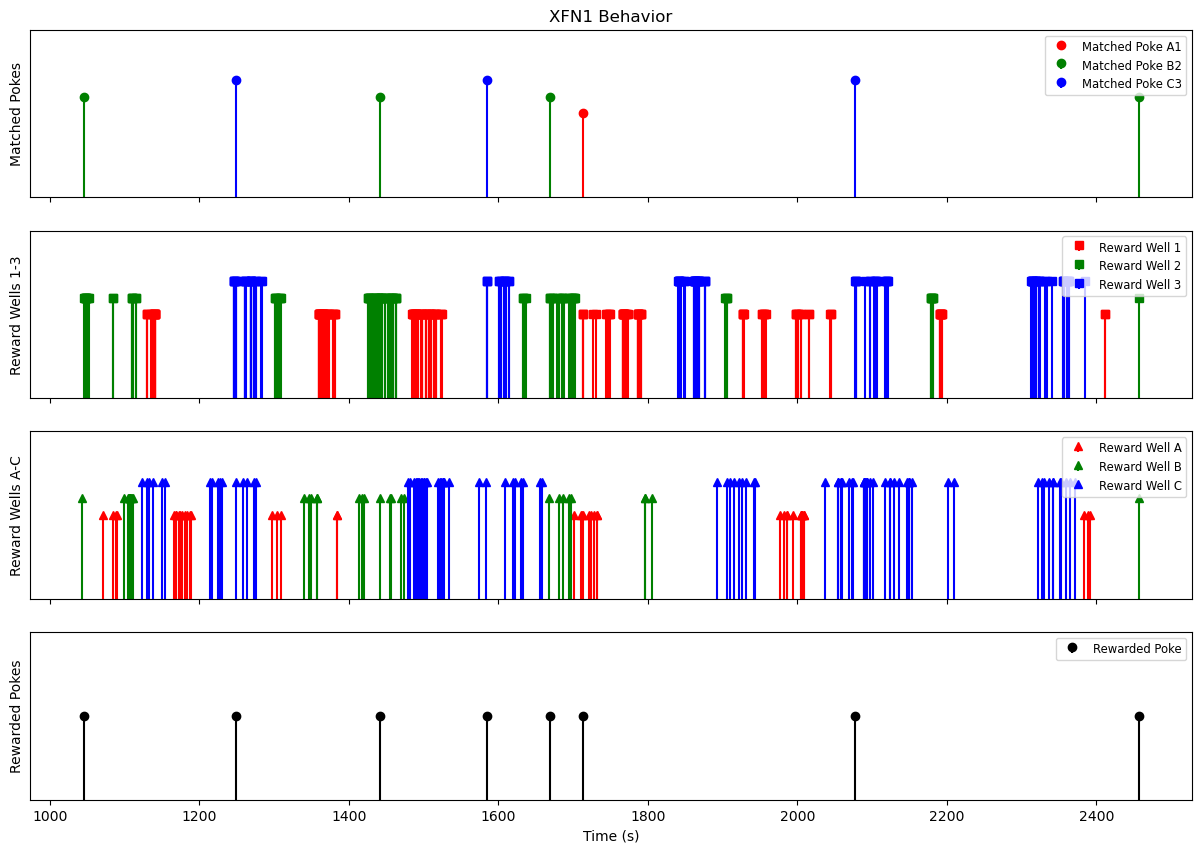

/var/folders/s3/qb42pmpn5jd0xb6fm2gt65qm0000gn/T/ipykernel_22160/1438950220.py:74: RuntimeWarning: Mean of empty slice
  x = np.nanmean(all_x, axis=0)
/var/folders/s3/qb42pmpn5jd0xb6fm2gt65qm0000gn/T/ipykernel_22160/1438950220.py:75: RuntimeWarning: Mean of empty slice
  y = np.nanmean(all_y, axis=0)


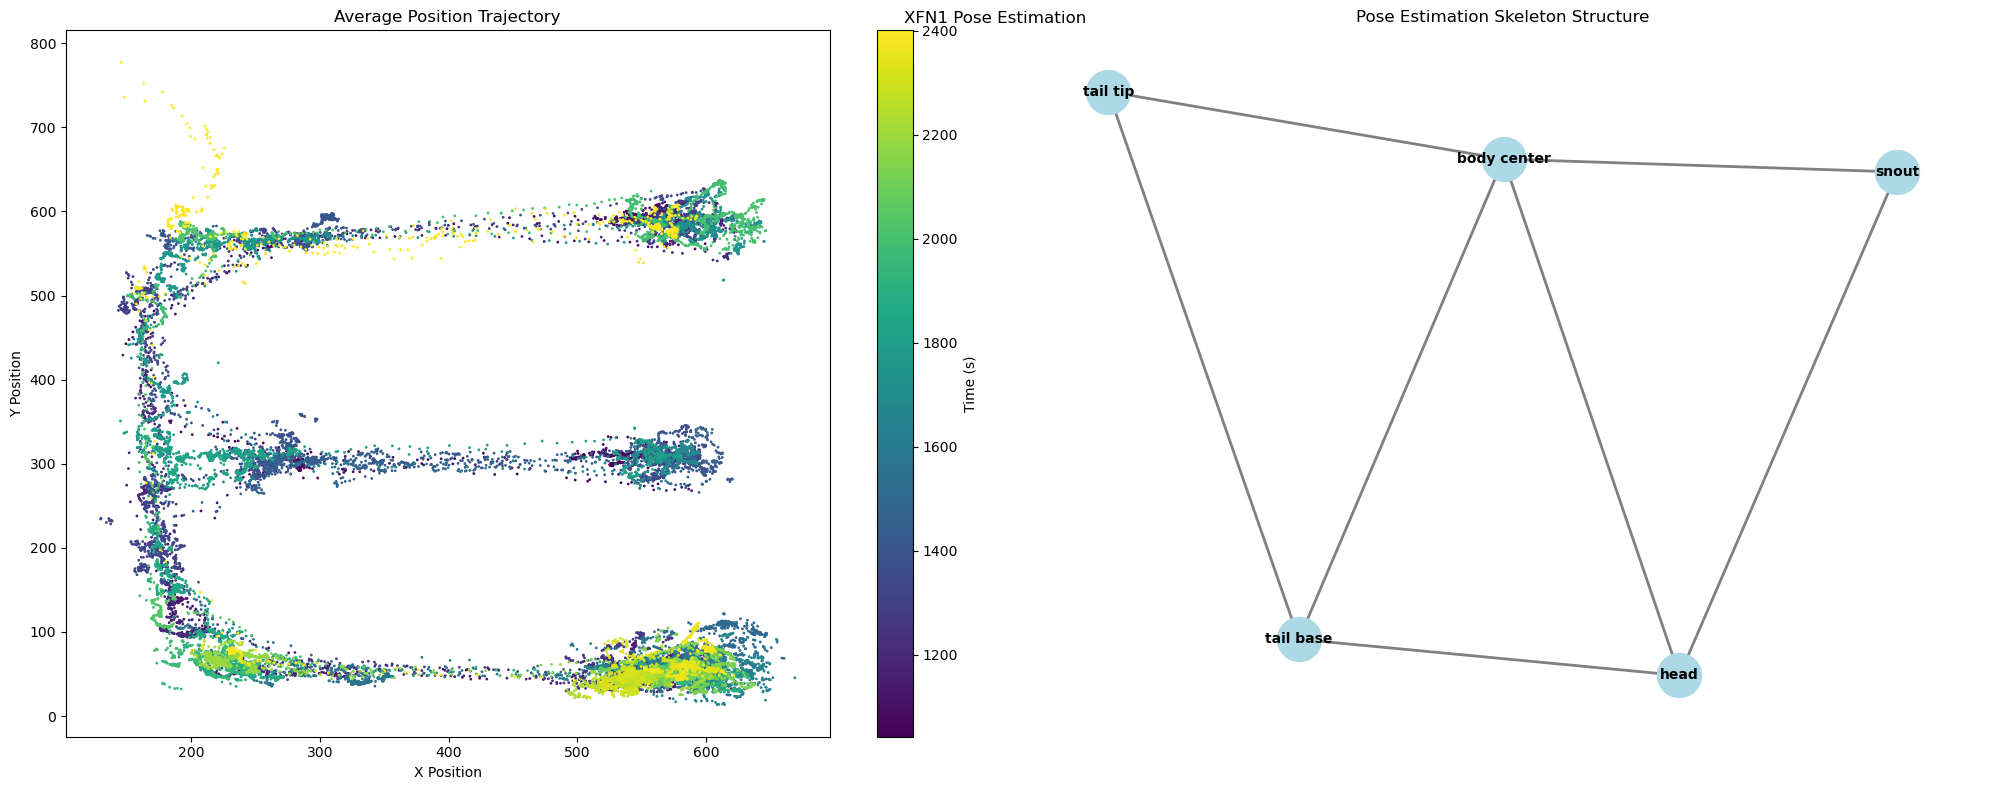

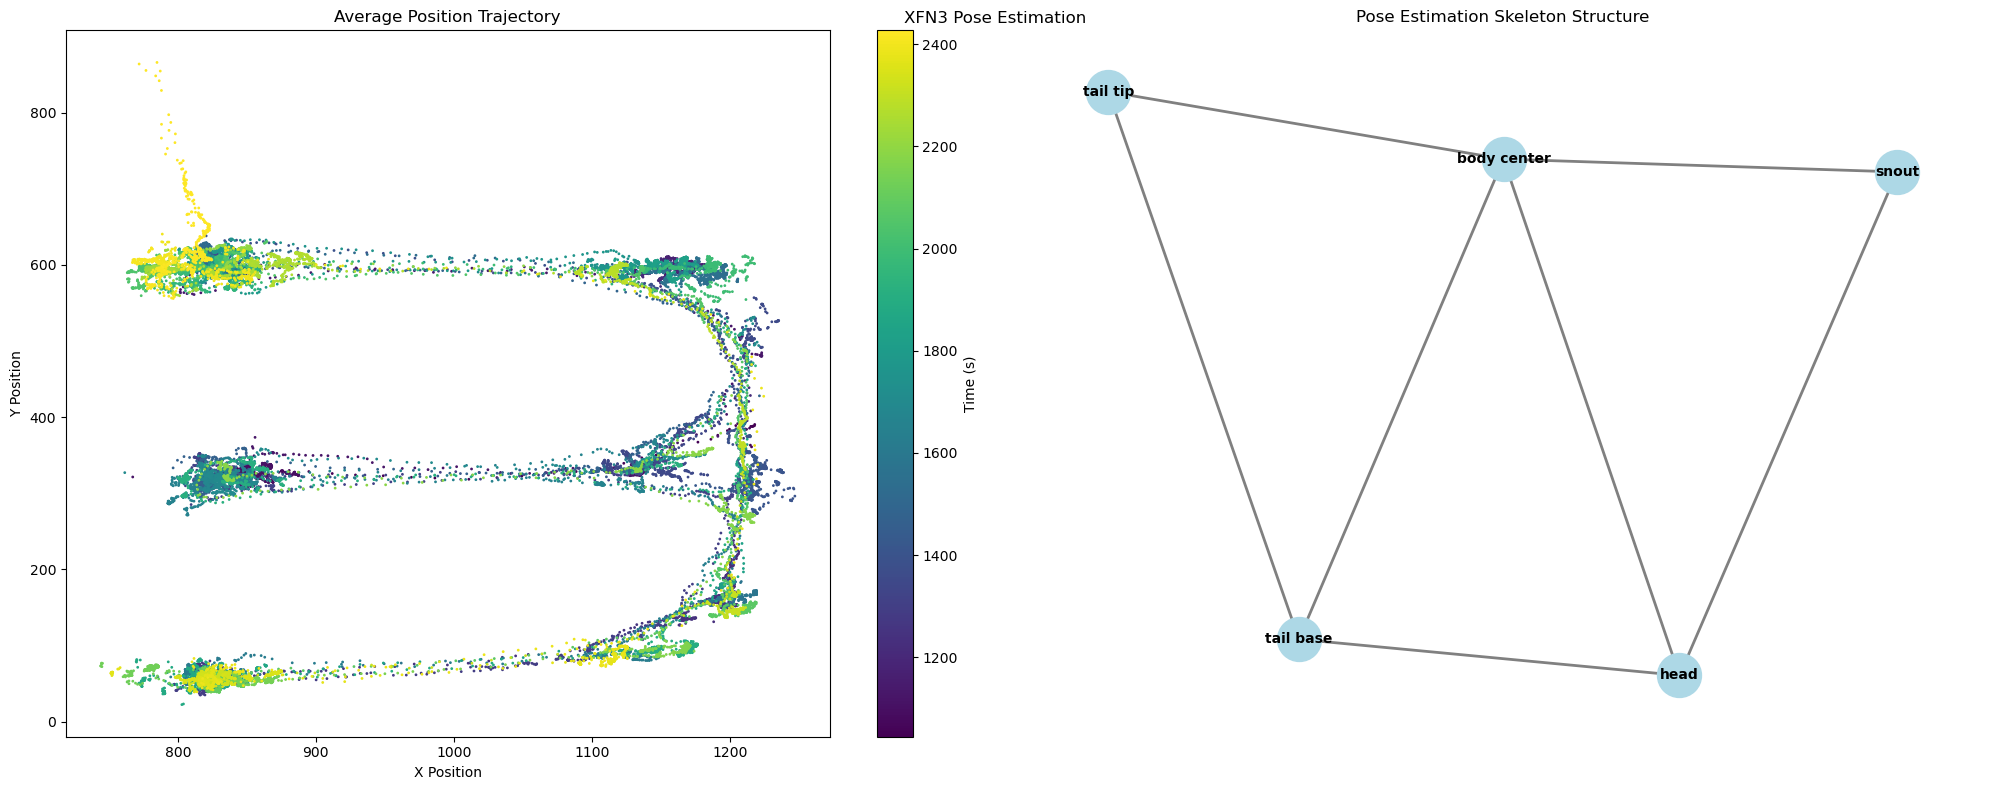

Data type,uint8
Shape,"(0, 0, 0)"
Array size,0.00 bytes
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,undefined
Data type,float64
Shape,"(42542,)"
Array size,332.36 KiB
Chunk shape,"(42542,)"


/opt/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.2.0 because version 0.1.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Data type,uint8
Shape,"(0, 0, 0)"
Array size,0.00 bytes
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,undefined
Data type,float64
Shape,"(42542,)"
Array size,332.36 KiB
Chunk shape,"(42542,)"


In [143]:
nwbfile_path_1 = Path("/Volumes/T7/CatalystNeuro/Spyglass/raw/sub-XFN1_ses-07-15-2023-100.nwb")
nwbfile_path_2 = Path("/Volumes/T7/CatalystNeuro/Spyglass/raw/sub-XFN3_ses-07-15-2023-100.nwb")
validate_nwb_session_pair(nwbfile_path_1, nwbfile_path_2, subject_1="XFN1", subject_2="XFN3")
plot_nwb_session_pair(nwbfile_path_1, nwbfile_path_2, subject_1="XFN1", subject_2="XFN3")
display_nwb_session_pair(nwbfile_path_1, nwbfile_path_2)